# EAST Scene Text Detection (Scratch Training) – ICDAR2015

**Objective**  
To build an end-to-end scene text detection pipeline using EAST, train it from scratch,
and establish a baseline for further lightweight detector research.

**Key Focus**
- End-to-end pipeline correctness
- Proper evaluation using ICDAR2015 protocol
- Recording accuracy + efficiency metrics


## Project setup

In [1]:
import os
import sys
import time
import random
import numpy as np
import torch

# Move to project root
PROJECT_ROOT = os.path.abspath("..")
os.chdir(PROJECT_ROOT)

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("Working directory:", os.getcwd())


Working directory: /DATA/akash/akash_cnn/lightweight-text-detector


/DATA/akash/miniconda3/envs/PytorchEAST/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Experiment CONFIG

In [2]:
# ===============================
# EXPERIMENT CONTROL
# ===============================

EXPERIMENT_NAME = "exp2_imagenet_vgg16"

USE_PRETRAINED = True      # True for Exp-2
PRETRAINED_TYPE = "imagenet"     # "imagenet" later

INPUT_SIZE = 512
EPOCHS = 20
BATCH_SIZE = 20
LEARNING_RATE = 1e-4

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


## Experiment Folder Setup

In [3]:
import os

EXP_ROOT = f"experiments/{EXPERIMENT_NAME}"

WEIGHTS_DIR = f"{EXP_ROOT}/weights"
LOG_DIR = f"{EXP_ROOT}/logs"
RESULTS_DIR = f"{EXP_ROOT}/results"
PRED_DIR = f"{RESULTS_DIR}/predictions"

for d in [WEIGHTS_DIR, LOG_DIR, PRED_DIR]:
    os.makedirs(d, exist_ok=True)

print("Experiment directories ready")


Experiment directories ready


## Dataset Paths

In [4]:
TRAIN_IMG_DIR = "data/icdar2015/ch4_train_images"
TEST_IMG_DIR  = "data/icdar2015/ch4_test_images"


## Model Initialization

In [5]:
from src.models.east import EAST

model = EAST(
    cfg="D",
    weights="imagenet" if USE_PRETRAINED else None
).to(DEVICE)

print(model.__class__.__name__, "initialized")


[INFO] Loading ImageNet pretrained VGG16_bn backbone


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /DATA/akash/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:08<00:00, 66.5MB/s] 


[INFO] ImageNet weights loaded successfully
EAST initialized


## Loss & Optimizer

In [6]:
from src.losses.loss import Loss

criterion = Loss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE
)


## DATASET + DATALOADER CELL

In [7]:
from torch.utils.data import DataLoader
from src.data.dataset import Dataset

# -------------------------
# Dataset
# -------------------------
train_dataset = Dataset(
    data_path=TRAIN_IMG_DIR,
    scale=0.25,
    length=INPUT_SIZE
)

# -------------------------
# DataLoader
# -------------------------
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True
)

print("Train loader ready")
print("Total training samples:", len(train_dataset))
print("Batches per epoch:", len(train_loader))


Train loader ready
Total training samples: 1000
Batches per epoch: 50


## Training Loop

In [8]:
from tqdm import tqdm
import torch

loss_log = []

for epoch in range(EPOCHS):
    model.train()

    epoch_geo_loss = 0.0
    epoch_cls_loss = 0.0

    pbar = tqdm(
        train_loader,
        desc=f"Epoch [{epoch+1}/{EPOCHS}]",
        dynamic_ncols=True
    )

    for imgs, gt_score, gt_geo, ignored_map in pbar:
        # -------------------------
        # Move to device
        # -------------------------
        imgs = imgs.to(DEVICE)
        gt_score = gt_score.to(DEVICE)
        gt_geo = gt_geo.to(DEVICE)
        ignored_map = ignored_map.to(DEVICE)

        # -------------------------
        # Forward
        # -------------------------
        pred_score, pred_geo = model(imgs)

        # -------------------------
        # EAST loss (guaranteed dict)
        # -------------------------
        loss_dict = criterion(
            gt_score, pred_score,
            gt_geo, pred_geo,
            ignored_map
        )

        geo_loss = loss_dict["geo_loss"]
        cls_loss = loss_dict["cls_loss"]

        total_loss = geo_loss + cls_loss

        # -------------------------
        # Backward
        # -------------------------
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # -------------------------
        # Logging
        # -------------------------
        epoch_geo_loss += geo_loss.item()
        epoch_cls_loss += cls_loss.item()

        pbar.set_postfix(
            geo=f"{geo_loss.item():.3f}",
            cls=f"{cls_loss.item():.3f}"
        )

    # -------------------------
    # Epoch summary
    # -------------------------
    avg_geo = epoch_geo_loss / len(train_loader)
    avg_cls = epoch_cls_loss / len(train_loader)

    loss_log.append({
        "epoch": epoch + 1,
        "geo_loss": avg_geo,
        "cls_loss": avg_cls
    })

    print(
        f"\nEpoch {epoch+1} Summary | "
        f"Geo Loss: {avg_geo:.4f} | "
        f"Cls Loss: {avg_cls:.4f}"
    )

    # -------------------------
    # Save checkpoint
    # -------------------------
    torch.save(
        model.state_dict(),
        f"{WEIGHTS_DIR}/epoch_{epoch+1}.pth"
    )

print("\nTraining finished successfully")


Epoch [1/20]: 100%|██████████| 50/50 [01:33<00:00,  1.88s/it, cls=0.989, geo=1.613]



Epoch 1 Summary | Geo Loss: 3.0272 | Cls Loss: 0.9892


Epoch [2/20]: 100%|██████████| 50/50 [01:35<00:00,  1.90s/it, cls=0.985, geo=1.496]



Epoch 2 Summary | Geo Loss: 1.4887 | Cls Loss: 0.9861


Epoch [3/20]: 100%|██████████| 50/50 [01:31<00:00,  1.84s/it, cls=0.989, geo=0.995]



Epoch 3 Summary | Geo Loss: 1.2289 | Cls Loss: 0.9830


Epoch [4/20]: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it, cls=0.983, geo=1.022]



Epoch 4 Summary | Geo Loss: 1.1261 | Cls Loss: 0.9830


Epoch [5/20]: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it, cls=0.983, geo=0.970]



Epoch 5 Summary | Geo Loss: 1.0322 | Cls Loss: 0.9826


Epoch [6/20]: 100%|██████████| 50/50 [01:33<00:00,  1.88s/it, cls=0.985, geo=0.847]



Epoch 6 Summary | Geo Loss: 0.9379 | Cls Loss: 0.9800


Epoch [7/20]: 100%|██████████| 50/50 [01:32<00:00,  1.86s/it, cls=0.990, geo=0.725]



Epoch 7 Summary | Geo Loss: 0.9612 | Cls Loss: 0.9803


Epoch [8/20]: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it, cls=0.979, geo=0.945]



Epoch 8 Summary | Geo Loss: 0.8981 | Cls Loss: 0.9791


Epoch [9/20]: 100%|██████████| 50/50 [01:33<00:00,  1.86s/it, cls=0.973, geo=0.771]



Epoch 9 Summary | Geo Loss: 0.8785 | Cls Loss: 0.9776


Epoch [10/20]: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it, cls=0.984, geo=0.770]



Epoch 10 Summary | Geo Loss: 0.8247 | Cls Loss: 0.9774


Epoch [11/20]: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it, cls=0.947, geo=0.802]



Epoch 11 Summary | Geo Loss: 0.7546 | Cls Loss: 0.9742


Epoch [12/20]: 100%|██████████| 50/50 [01:32<00:00,  1.86s/it, cls=0.969, geo=0.808]



Epoch 12 Summary | Geo Loss: 0.7241 | Cls Loss: 0.9760


Epoch [13/20]: 100%|██████████| 50/50 [01:33<00:00,  1.88s/it, cls=0.988, geo=0.888]



Epoch 13 Summary | Geo Loss: 0.7920 | Cls Loss: 0.9744


Epoch [14/20]: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it, cls=0.975, geo=0.762]



Epoch 14 Summary | Geo Loss: 0.7127 | Cls Loss: 0.9739


Epoch [15/20]: 100%|██████████| 50/50 [01:34<00:00,  1.88s/it, cls=0.969, geo=0.674]



Epoch 15 Summary | Geo Loss: 0.6968 | Cls Loss: 0.9724


Epoch [16/20]: 100%|██████████| 50/50 [01:32<00:00,  1.86s/it, cls=0.971, geo=0.696]



Epoch 16 Summary | Geo Loss: 0.6982 | Cls Loss: 0.9711


Epoch [17/20]: 100%|██████████| 50/50 [01:33<00:00,  1.88s/it, cls=0.985, geo=0.530]



Epoch 17 Summary | Geo Loss: 0.6539 | Cls Loss: 0.9731


Epoch [18/20]: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it, cls=0.978, geo=0.521]



Epoch 18 Summary | Geo Loss: 0.6194 | Cls Loss: 0.9704


Epoch [19/20]: 100%|██████████| 50/50 [01:33<00:00,  1.88s/it, cls=0.981, geo=0.654]



Epoch 19 Summary | Geo Loss: 0.6242 | Cls Loss: 0.9706


Epoch [20/20]: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it, cls=0.975, geo=0.657]


Epoch 20 Summary | Geo Loss: 0.5860 | Cls Loss: 0.9682

Training finished successfully


## Dataset Statistics

In [9]:
print("===== DATASET STATISTICS =====")
print("Train images:", len(os.listdir(TRAIN_IMG_DIR)))
print("Test images :", len(os.listdir(TEST_IMG_DIR)))


===== DATASET STATISTICS =====
Train images: 1000
Test images : 500


## Model Size

In [10]:
def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

total_params, trainable_params = count_params(model)

print("===== MODEL SIZE =====")
print(f"Total params     : {total_params/1e6:.2f} M")
print(f"Trainable params : {trainable_params/1e6:.2f} M")


===== MODEL SIZE =====
Total params     : 15.09 M
Trainable params : 15.09 M


## FLOPs

In [11]:
from thop import profile

dummy = torch.randn(1, 3, INPUT_SIZE, INPUT_SIZE).to(DEVICE)
flops, _ = profile(model, inputs=(dummy,), verbose=False)

print("===== COMPUTE COST =====")
print(f"GFLOPs @ {INPUT_SIZE}x{INPUT_SIZE}: {flops/1e9:.2f}")


===== COMPUTE COST =====
GFLOPs @ 512x512: 81.41


## Single Image Inference

In [13]:
from PIL import Image
from src.detect import detect

model.eval()

img_name = sorted(os.listdir(TEST_IMG_DIR))[0]
img_path = os.path.join(TEST_IMG_DIR, img_name)
img = Image.open(img_path).convert("RGB")

boxes = detect(img, model, DEVICE)

print("Image:", img_name)
print("Detected boxes:", 0 if boxes is None else len(boxes))


Image: img_1.jpg
Detected boxes: 10


## Single Image Visualization

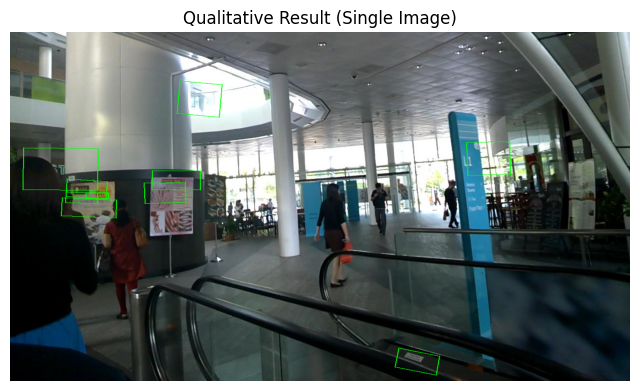

In [14]:
from PIL import ImageDraw
import matplotlib.pyplot as plt

draw = ImageDraw.Draw(img)

if boxes is not None:
    for box in boxes:
        pts = [
            (box[0], box[1]),
            (box[2], box[3]),
            (box[4], box[5]),
            (box[6], box[7])
        ]
        draw.polygon(pts, outline="lime", width=2)

plt.figure(figsize=(8,8))
plt.imshow(img)
plt.axis("off")
plt.title("Qualitative Result (Single Image)")
plt.show()


## Inference Time + FPS + GPU Memory

In [15]:
import time
from torchvision import transforms

torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

w, h = img.size
img_r = img.resize(((w//32)*32, (h//32)*32))

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3)
])

img_tensor = transform(img_r).unsqueeze(0).to(DEVICE)

with torch.no_grad():
    for _ in range(5):
        _ = model(img_tensor)

torch.cuda.synchronize()
start = time.time()

with torch.no_grad():
    _ = model(img_tensor)

torch.cuda.synchronize()
end = time.time()

infer_time = (end - start) * 1000
fps = 1000 / infer_time
peak_mem = torch.cuda.max_memory_allocated() / (1024**3)

print("===== INFERENCE PERFORMANCE =====")
print(f"Inference time : {infer_time:.2f} ms")
print(f"FPS            : {fps:.2f}")
print(f"Peak GPU mem   : {peak_mem:.2f} GB")


===== INFERENCE PERFORMANCE =====
Inference time : 27.76 ms
FPS            : 36.03
Peak GPU mem   : 1.40 GB


## Metrics JSON

In [16]:
import json

final_metrics = {
    "experiment": EXPERIMENT_NAME,
    "dataset": "ICDAR2015",
    "training": loss_log[-1],
    "model": {
        "params_million": total_params / 1e6,
        "gflops": flops / 1e9
    },
    "inference": {
        "time_ms": infer_time,
        "fps": fps,
        "gpu_mem_gb": peak_mem
    }
}

with open(os.path.join(EXP_ROOT, "metrics.json"), "w") as f:
    json.dump(final_metrics, f, indent=2)

print("metrics.json saved")

metrics.json saved


## Save Loss Logs

In [17]:
import json

with open(f"{LOG_DIR}/loss_log.json", "w") as f:
    json.dump(loss_log, f, indent=2)

print("Loss log saved")


Loss log saved


## Batch Inference

In [18]:
from tqdm import tqdm
from PIL import Image
from src.detect import detect

model.eval()

with torch.no_grad():
    pbar = tqdm(sorted(os.listdir(TEST_IMG_DIR)), desc="Batch inference")

    for name in pbar:
        if not name.lower().endswith((".jpg", ".png")):
            continue

        pbar.set_postfix_str(name)

        img = Image.open(os.path.join(TEST_IMG_DIR, name)).convert("RGB")
        boxes = detect(img, model, DEVICE)

        txt_path = os.path.join(
            PRED_DIR, f"res_{os.path.splitext(name)[0]}.txt"
        )

        with open(txt_path, "w") as f:
            if boxes is not None:
                for box in boxes:
                    f.write(",".join(str(int(v)) for v in box[:8]) + "\n")

print("Batch inference done")


Batch inference: 100%|██████████| 500/500 [00:51<00:00,  9.67it/s, img_99.jpg] 

Batch inference done


## ZIP Creation

In [19]:
import zipfile

submit_zip = f"{RESULTS_DIR}/submit.zip"

with zipfile.ZipFile(submit_zip, "w", zipfile.ZIP_DEFLATED) as z:
    for file in os.listdir(PRED_DIR):
        if file.endswith(".txt"):
            z.write(os.path.join(PRED_DIR, file), arcname=file)

print("submit.zip created")


submit.zip created


In [20]:
!python evaluate/script.py \
-g=evaluate/gt.zip \
-s=experiments/exp1_scratch_vgg16/results/submit.zip


Calculated!{"precision": 0.024202510804692323, "recall": 0.2831006259027443, "hmean": 0.04459274988624298, "AP": 0}

In [21]:
# =====================================================
# FINAL FIXED ICDAR METRIC EXTRACTION (100% SAFE)
# =====================================================

import subprocess
import re
import json
import os

GT_ZIP = "evaluate/gt.zip"
SUBMIT_ZIP = f"{EXP_ROOT}/results/submit.zip"
METRICS_JSON = f"{EXP_ROOT}/metrics.json"

cmd = [
    "python", "evaluate/script.py",
    f"-g={GT_ZIP}",
    f"-s={SUBMIT_ZIP}"
]

result = subprocess.run(
    cmd,
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True
)

output = result.stdout
print(output)

# ----------------------------
# Safe metric extractor
# ----------------------------
def find_metric(pattern, text, group_idx):
    m = re.search(pattern, text, re.IGNORECASE)
    return float(m.group(group_idx)) if m else None

# ----------------------------
# Try standard patterns
# ----------------------------
precision = find_metric(
    r"precision[^0-9]*([0-9]+\.[0-9]+)", output, 1
)

recall = find_metric(
    r"recall[^0-9]*([0-9]+\.[0-9]+)", output, 1
)

f1 = find_metric(
    r"(f[- ]?measure|hmean)[^0-9]*([0-9]+\.[0-9]+)", output, 2
)

# ----------------------------
# Fallback: table format
# ----------------------------
if f1 is None:
    rows = re.findall(
        r"\|\s*([0-9]+\.[0-9]+)\s*\|\s*([0-9]+\.[0-9]+)\s*\|\s*([0-9]+\.[0-9]+)\s*\|",
        output
    )
    if rows:
        precision, recall, f1 = map(float, rows[-1])

# ----------------------------
# Final sanity check
# ----------------------------
if f1 is None:
    raise RuntimeError("ICDAR metrics could not be extracted. Check printed output.")

# ----------------------------
# Save to metrics.json
# ----------------------------
with open(METRICS_JSON, "r") as f:
    metrics = json.load(f)

metrics["icdar"] = {
    "precision": precision,
    "recall": recall,
    "f_measure": f1
}

with open(METRICS_JSON, "w") as f:
    json.dump(metrics, f, indent=2)

print("ICDAR metrics saved successfully")
metrics["icdar"]


Calculated!{"precision": 0.08932153392330383, "recall": 0.3644679826673086, "hmean": 0.14347990902198635, "AP": 0}
ICDAR metrics saved successfully


{'precision': 0.08932153392330383,
 'recall': 0.3644679826673086,
 'f_measure': 0.14347990902198635}